In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import prolif as plf

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
pdb = '2zdt'

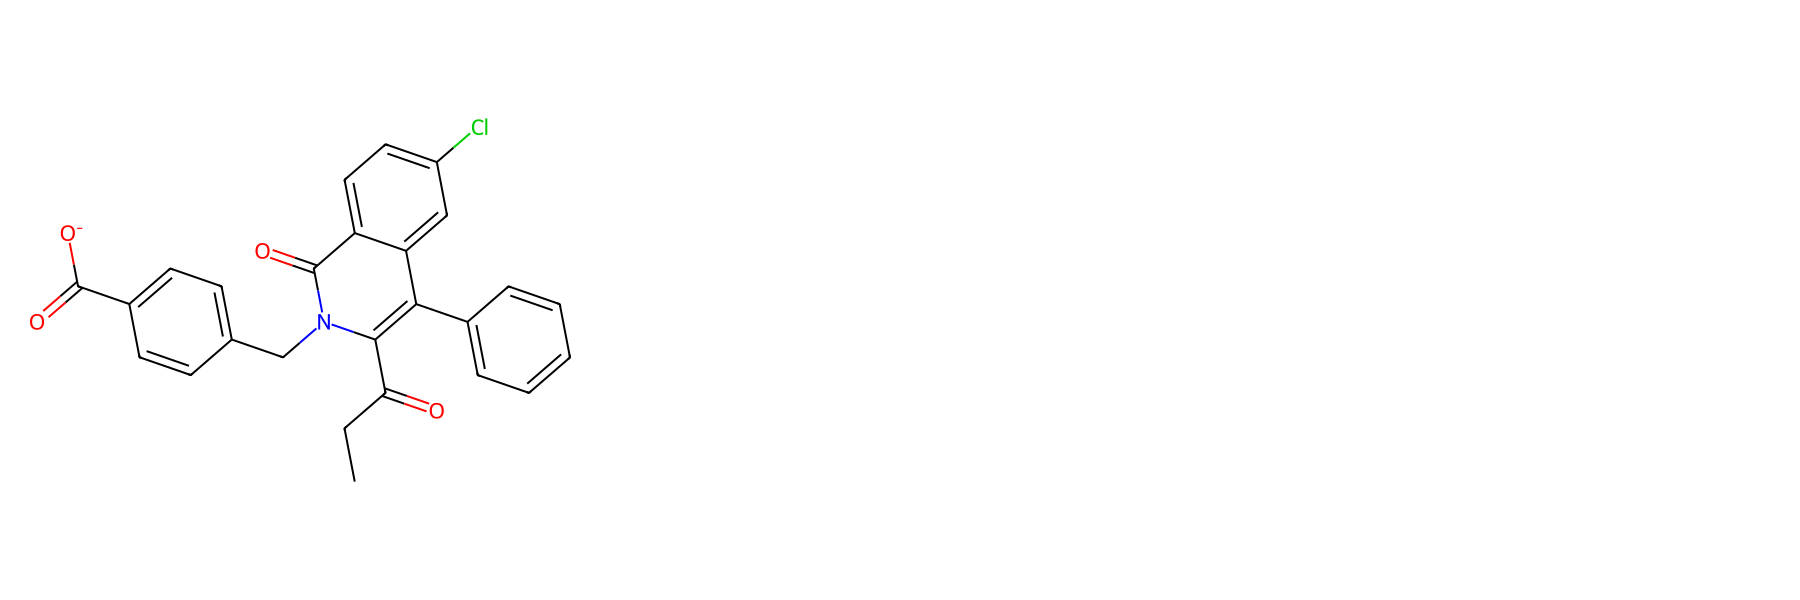

In [4]:
initial_mol = Chem.MolFromMolFile(f"data/docking/{pdb}_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

MolsToGridImage([Chem.MolFromSmiles(initial)], subImgSize=(600, 600))

In [5]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

### Interaction fingerprint for reference molecule

In [6]:
REF_MOL_FILEPATH = f"data/docking/{pdb}_ligand.sdf"
PDB_FILEPATH = f"data/docking/{pdb}.pdb"

fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(REF_MOL_FILEPATH)
fp.run_from_iterable(suppl, prot, progress=True)
df_ifp = fp.to_dataframe()
df_ifp.columns = df_ifp.columns.droplevel(0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_ifp

protein        LYS68.A                        ILE70.A    GLY71.A     VAL78.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                          
0                 True    True       True        True       True        True   

protein                    ALA91.A               ILE124.A  ...   ASN152.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic  ... VdWContact   
Frame                                                      ...              
0                 True        True       True        True  ...       True   

protein       SER193.A    VAL196.A               LEU206.A    46C901.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

protein                             HOH986.A             
interaction PiStacking VdWContact HBAcceptor VdWContact  
Frame                                                    
0                 True       True       True       True  

[1 rows x 28 columns]

In [8]:
def ifp_similarity(ref_mol_ifp, df_ifp, df):
    ## Rename columns
    df_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in df_ifp.columns]
    ref_mol_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in ref_mol_ifp.columns]
    

    intersections = []
    weighted_intersections = []

    #iterate over the rows
    for index, row in df_ifp.iterrows():
        count=0
        weighted_count = 0
        #iterate over all columns
        for col_name in df_ifp.columns:
            if col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'VdWContact' in col_name:
                count += 1
                weighted_count += 1
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Hydrophobic' in col_name:
                count += 1
                weighted_count += 2
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'HBAcceptor' in col_name:
                count += 1
                weighted_count += 3
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Anionic' in col_name or 'Cationic' in col_name:
                count += 1
                weighted_count += 4
        
        intersections.append(count)
        weighted_intersections.append(weighted_count)
                
    df['IFP Intersection'] = intersections
    df['Weighted IFP Intersection'] = weighted_intersections

    return df


In [9]:
# Function that takes as input two dataframes with the same number of rows and computes number of IMFs of each molecule wrt protein
def compute_features(df, ifp):

   # List of new columns to add
    new_columns = ['num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']

    # Create a dictionary of new columns with pd.NA values
    new_cols_dict = {col: pd.NA for col in new_columns}

    # Add multiple empty columns
    df = df.assign(**new_cols_dict)
   
    cols = ifp.columns

    data = {'mol_id' : [],
            'num_interactions' : [],
            'weighted_interactions' : [],
            'num_VdW' : [],
            'num_hydrophobic' : [],
            'num_HBAcceptor' : [],
            'num_ionic' : []}
    
    for index, row in ifp.iterrows():

        weighted_interactions = 0
        num_VdW = 0
        num_hydrophobic = 0
        num_HBAcceptor = 0
        num_ionic = 0
        
        # data['mol_id'].append(df.row['ID'][0])
        # data['num_interactions'].append(row[:-1].sum())

        for value in cols:
            
            if value[1] == 'VdWContact':
                weighted_interactions += 1 * row[value]
                num_VdW += 1 * row[value]
            elif value[1] == 'Hydrophobic':
                weighted_interactions += 2 * row[value]
                num_hydrophobic += 1 * row[value]
            elif value[1] == 'HBAcceptor':
                weighted_interactions += 3 * row[value]
                num_HBAcceptor += 1 * row[value]
            elif value[1] == 'Anionic' or value[1] == 'Cationic':
                weighted_interactions += 4 * row[value]
                num_ionic += 1 * row[value]

            num_interactions=num_VdW + num_HBAcceptor + num_hydrophobic + num_ionic
        df['weighted_interactions'][index]=weighted_interactions
        df['num_VdW'][index]=num_VdW
        df['num_hydrophobic'][index]=num_hydrophobic
        df['num_HBAcceptor'][index]=num_HBAcceptor
        df['num_ionic'][index]=num_ionic
        df['num_interactions'][index]=num_interactions
    
    
    
    return df 

    ### OLD CODE IN CASE FUNCTION DOESN'T WORK
    
    # data['weighted_interactions'].append(weighted_interactions)
    # data['num_VdW'].append(num_VdW)
    # data['num_hydrophobic'].append(num_hydrophobic)
    # data['num_HBAcceptor'].append(num_HBAcceptor)
    # data['num_ionic'].append(num_ionic) 

    # features = pd.DataFrame(data)
    
    # df = df.append(features[['mol_id', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']], left_on='ID', right_on='mol_id', how='left')

    # df = df.drop(['mol_id'], axis=1).sort_values(['Docking score'], ascending=True)

    # df.dropna(axis=0, subset=['Docking score'], inplace=True)
    # df['num_interactions'].fillna(0, inplace=True)
    # df['weighted_interactions'].fillna(0, inplace=True)

In [10]:
def visualize_fingerprint(ifp):

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(ifp,cmap=sns.cm.rocket_r)
    ax.set_ylabel("Molecule")
    ax.set_xlabel("Protein Interaction")

    return ax

## Reinvent

In [25]:
model = 'reinvent'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [12]:
model = 'reinvent'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_reinvent = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_reinvent = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

Compute metrics

In [13]:
#Compute length to check that no molecules are being filtered by metric computation
len(df_reinvent)

200

In [14]:
#number of IMFs
df_reinvent = compute_features(df_reinvent, ifp_reinvent)
# Compare IMFs to initial fragment
df_reinvent = ifp_similarity(df_ifp, ifp_reinvent, df_reinvent)

df_reinvent.drop(['Input_SMILES', 'Prior', 'Tanimoto'], axis=1, inplace=True)
df_reinvent['Model'] = model


In [15]:
#Check that number of rows matches and visualize data_frame
df_reinvent

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model
0,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,MOL0000,-15.362548,7.373597,24,40,11,10,3,0,21,40,reinvent
1,CCC(=O)c1c(-c2ccccc2)c2ccccc2c(=O)n1Cc1ccc(C(=...,MOL0001,-13.758682,5.770615,23,38,10,11,2,0,21,39,reinvent
2,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,MOL0002,-14.847966,5.495695,27,42,14,11,2,0,22,40,reinvent
3,Cc1[nH]nc(C#N)c1C,MOL0003,-5.760766,4.607175,24,39,11,11,2,0,22,40,reinvent
4,CCC(=O)c1c(-c2ccc(S(C)(=O)=O)cc2)c2cc(Cl)ccc2c...,MOL0004,-11.602587,9.200715,25,41,11,12,2,0,22,40,reinvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,CCCOc1n[nH]c(N)c1C#N,MOL0195,-8.145748,4.669519,10,15,5,5,0,0,10,18,reinvent
196,CCC(C)c1n[nH]c(N)c1C#N,MOL0196,-6.821373,9.159095,12,20,5,6,1,0,11,22,reinvent
197,CCNc1[nH]nc(C)c1C#N,MOL0197,-6.320854,12.014053,10,17,4,5,1,0,9,19,reinvent
198,CC(C)n1cc(C#N)c(C#N)c1,MOL0198,-6.897991,10.311777,10,14,6,4,0,0,10,17,reinvent


### CReM

In [26]:
model = 'crem'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [17]:
model = 'crem'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_crem = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_crem = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [18]:
len(ifp_crem)

199

In [19]:
#Compute length to check that no molecules are being filtered by metric computation
len(df_reinvent)

200

Compute metrics

In [20]:
#number of IMFs
df_crem = compute_features(df_crem, ifp_crem)
len(df_crem)

200

In [21]:
# Compare IMFs to initial fragment
df_crem = ifp_similarity(df_ifp, ifp_crem, df_crem)

ValueError: Length of values (199) does not match length of index (200)

In [ ]:
df_crem

,SMILES,Model
1468,NP(N)(=O)Oc1ccccc1,crem
33,Nc1nc(Br)cn2ccnc12,crem
8,CC(C)CC(C)(N)C#N,crem
4550,CC(=O)C#Cc1ccccc1,crem
889,NN=C1C(Cl)=C(Cl)C(Cl)=C1Cl,crem
...,...,...
1039,COC(=O)Cc1nnc(N)s1,crem
5103,CC1=CCCCC1=NO,crem
439,C=C(CN)c1cccs1,crem
2487,CC1(C)C(Cl)(Cl)C1(C)C(=O)O,crem


In [ ]:
model_df = pd.concat((df_reinvent, df_crem))

### Coati

In [27]:
model = 'coati'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay


/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [ ]:
model = 'coati'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_coati = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_coati = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [ ]:
ifp_coati

protein        LYS68.A                        ILE70.A               GLY71.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact VdWContact   
Frame                                                                         
0                 True    True       True        True       True       True   
1                 True    True       True        True       True       True   
2                 True    True       True        True       True       True   
3                 True    True       True        True       True       True   
4                 True    True       True        True       True       True   
...                ...     ...        ...         ...        ...        ...   
193              False   False      False        True       True       True   
194               True    True       True        True       True       True   
195              False    True      False        True       True       True   
196              False   False      False        True       True       True   
197              False    True      False        True       True      False   

protein        SER72.A               GLY73.A     VAL78.A  ...   HOH986.A  \
interaction HBAcceptor VdWContact VdWContact Hydrophobic  ... HBAcceptor   
Frame                                                     ...              
0                False      False      False        True  ...       True   
1                False       True      False        True  ...       True   
2                False      False      False        True  ...      False   
3                False      False      False        True  ...      False   
4                False       True      False        True  ...      False   
...                ...        ...        ...         ...  ...        ...   
193              False       True      False        True  ...      False   
194              False       True      False        True  ...       True   
195              False      False      False        True  ...      False   
196              False      False      False        True  ...      False   
197              False       True      False        True  ...      False   

protein                  HOH988.A   HOH992.A             HOH1042.A             \
interaction VdWContact VdWContact HBAcceptor VdWContact HBAcceptor VdWContact   
Frame                                                                           
0                 True      False      False      False      False      False   
1                 True      False      False      False      False      False   
2                False      False      False      False      False      False   
3                False      False      False      False      False      False   
4                 True      False      False      False      False       True   
...                ...        ...        ...        ...        ...        ...   
193              False      False      False      False      False       True   
194               True      False      False      False      False       True   
195              False      False      False      False      False       True   
196              False      False      False       True      False       True   
197              False      False      False      False      False      False   

protein      HOH1045.A                             ID  
interaction HBAcceptor VdWContact Unnamed: 75_level_1  
Frame                                                  
0                False      False             MOL0034  
1                False      False             MOL0186  
2                False      False             MOL0129  
3                False      False             MOL0162  
4                False       True             MOL0087  
...                ...        ...                 ...  
193              False       True             MOL0130  
194              False      False             MOL0012  
195              False      False             MOL0056  
196              Fals

In [ ]:
df_coati = compute_features(df_coati, ifp_coati)

KeyError: 'ID'

In [ ]:
df_coati = ifp_similarity(df_ifp, ifp_coati, df_coati)

In [ ]:
model_df = pd.concat((model_df, df_coati))

### SAFE

In [28]:
model = 'safe'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [ ]:
model = 'safe'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_safe = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_safe = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [ ]:
df_safe = compute_features(df_safe, ifp_safe)

In [ ]:
df_safe = ifp_similarity(df_ifp, ifp_safe, df_safe)

In [ ]:
model_df = pd.concat((model_df, df_safe))

In [ ]:
model_df.head()

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,21,39,reinvent
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,24,41,reinvent
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,20,36,reinvent
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,22,38,reinvent
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,20,35,reinvent


In [ ]:
smiles = model_df['SMILES'].to_list()

In [ ]:
y = model_df['Model'].to_numpy().reshape(-1, 1)

### Evaluating Metrics w/ MolScore

In [32]:
from molscore import MolScore

In [33]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8025 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [34]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

In [413]:
df = pd.read_csv('molscore/2024_07_23_mol2mol_feature_selection/iterations/000001_scores.csv', index_col=0)

In [414]:
df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,3.020867,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,8.633502
1,mol2mol,feature_selection,1,1,3.020867,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,8.633502
2,mol2mol,feature_selection,1,2,3.020867,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,8.633502
3,mol2mol,feature_selection,1,3,3.020867,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,8.633502
4,mol2mol,feature_selection,1,4,3.020867,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,8.633502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,mol2mol,feature_selection,1,789,3.020867,COc1ccc(C2Oc3ccccc3C3CC(O)CCC32CNS(=O)(=O)c2cc...,True,1,True,0,...,0,0.107143,0.107143,0.193548,0.193548,0.004684,1,1.0,1.0,8.633502
790,mol2mol,feature_selection,1,790,3.020867,Cc1ccccc1Cc1noc(C[NH+]2CCC(C(N)=O)([NH+]3CCCCC...,True,1,True,0,...,0,0.117021,0.117021,0.209524,0.209524,0.841454,1,1.0,1.0,8.633502
791,mol2mol,feature_selection,1,791,3.020867,CCOc1ccc([C@@H](C)NC(=O)CNC(=O)c2cccc(F)c2)cc1OCC,True,1,True,0,...,1,0.149425,0.149425,0.260000,0.260000,0.998503,1,1.0,1.0,8.633502
792,mol2mol,feature_selection,1,792,3.020867,COc1ccc(OC)c([C@@H]2CC(=O)C3=C(C2)Nc2ccccc2N[C...,True,1,True,0,...,0,0.110092,0.110092,0.198347,0.198347,0.198908,1,1.0,1.0,8.633502


In [415]:
# df.drop(['desc_MolecularFormula', 'dice_Cmpd1_Sim', 'tanimoto_Cmpd1_Sim', 'desc_SAscore', 'desc_PenLogP'], axis=1, inplace=True)

In [416]:
X = df.drop(['smiles', 'model', 'task', 'step',
            'batch_idx', 'absolute_time',
            'valid', 'valid_score', 'unique',
            'occurrences', 'desc_MolecularFormula',
            'dice_Sim', 'dice_Cmpd1_Sim',
            'tanimoto_Sim', 'tanimoto_Cmpd1_Sim',
            'desc_SAscore', 'desc_PenLogP',
            'desc_MolWt', 'desc_NumHAcceptors',
            'desc_NumHDonors', 'desc_CLogP',
            'desc_TPSA', 'desc_NumRotatableBonds',
            'desc_MaxConsecutiveRotatableBonds',
            'desc_NumAromaticRings', 'desc_FlourineCount',
            'desc_FormalCharge', 'desc_RingCount',
            'desc_NumAliphaticRings', 'desc_HeavyAtomCount',
            'desc_HeavyAtomMolWt', 'amean', 'filter',
            'score_time', 'raw_valid_score'], axis=1)

In [471]:
model_df['num_interactions'][:200].nunique(), model_df['num_interactions'][200:400].nunique(), model_df['num_interactions'][400:600].nunique(), model_df['num_interactions'][600:].nunique()

(14, 14, 16, 21)

Adding new features

In [417]:
weighted_ifp_intersection = model_df['Weighted IFP Intersection'].values
X['Weighted IFP Similarity'] = weighted_ifp_intersection / model_df['weighted_interactions'].values

X['Docking score'] = model_df['Docking score'].values
X['rmsd'] = model_df['rmsd'].values
# X['num_interactions'] = model_df['num_interactions'].values
# X['weighted_interactions'] = model_df['weighted_interactions'].values
X['Interaction Weight Ratio'] = model_df['weighted_interactions'].values / model_df['num_interactions'].values

In [418]:
# X['Docking score'] = model_df['Docking score'].values
# X['num_interactions'] = model_df['num_interactions'].values
# X['weighted_interactions'] = model_df['weighted_interactions'].values
# X['interaction weight ratio'] = model_df['weighted_interactions'].values / model_df['num_interactions'].values
# X['num_VdW'] = model_df['num_VdW'].values
# X['num_hydophobic'] = model_df['num_hydrophobic'].values
# X['num_HBAcceptor'] = model_df['num_HBAcceptor'].values
# X['num_ionic'] = model_df['num_ionic'].values
# X['CLogP * num_interactions'] = df['desc_CLogP'] * X['num_interactions']
# X['CLogP * weighted_interactions'] = df['desc_CLogP'] * X['weighted_interactions']
# X['rmsd'] = model_df['rmsd'].values
# X['IFP Intersection'] = model_df['IFP Intersection'].values
# X['Weighted IFP Intersection'] = model_df['Weighted IFP Intersection'].values
# X['IFP Similarity'] = X['IFP Intersection'].values / model_df['num_interactions'].values
# X['Weighted IFP Similarity'] = X['Weighted IFP Intersection'].values / model_df['weighted_interactions'].values

In [419]:
X.head()

,desc_QED,desc_NumHeteroatoms,desc_Bertz,RAScore_pred_proba,Weighted IFP Similarity,Docking score,rmsd,Interaction Weight Ratio
0,0.351621,9,1507.458087,0.982867,0.866667,-16.624857,3.737471,1.666667
1,0.340885,7,1488.314380,0.948534,0.854167,-16.540930,3.676144,1.500000
2,0.271819,6,1406.508497,0.910709,0.900000,-16.529593,5.569642,1.600000
3,0.397044,7,1467.520115,0.945486,0.844444,-16.301600,3.785833,1.551724
4,0.387424,8,1470.935757,0.957991,0.833333,-16.295380,5.360354,1.555556


#### Exploratory Data Analysis:

* Normalizing columns
* Evaluating correlations between features

In [420]:
column_names = {
    'desc_QED' : 'QED',
    'desc_Bertz' : 'Synthetic Complexity',
    'interaction weight ratio' : 'Avg Interaction Strength',
    'Weighted IFP Similarity' : 'Weighted Interaction Similarity',
    'rmsd' : 'RMSD',
    'RAScore_pred_proba' : 'Synthetic Accessibility',
    'desc_NumHeteroatoms' : '# Heteroatoms'
}

X.rename(columns=column_names, inplace=True)

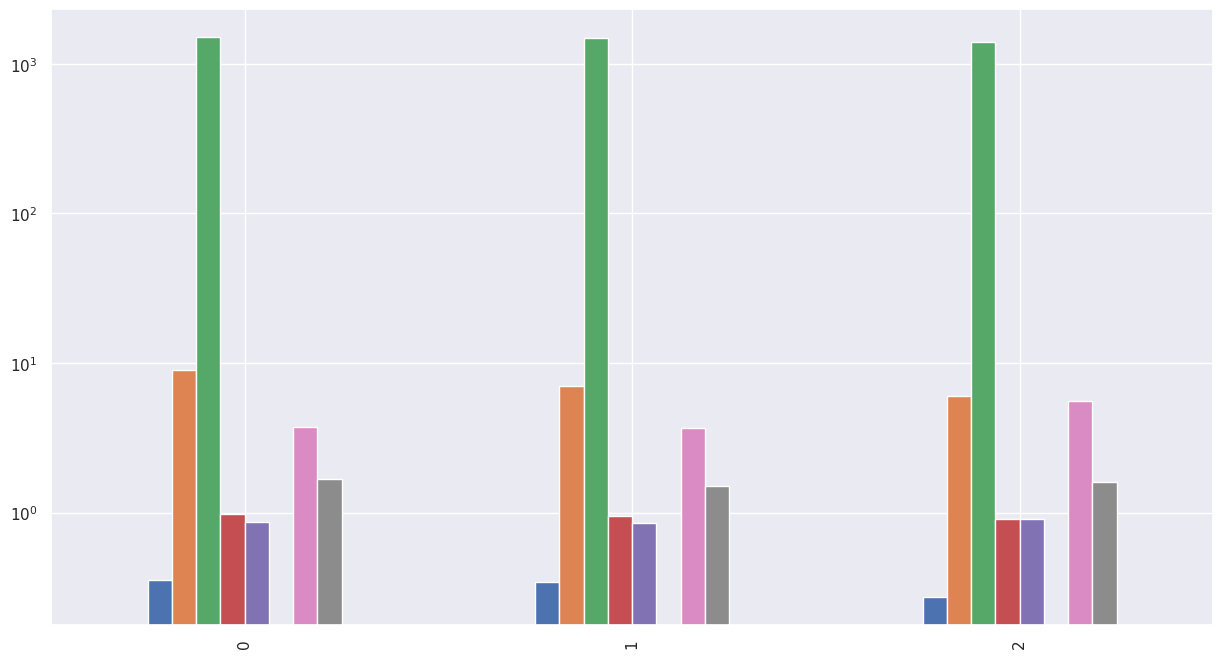

In [421]:
X[:3].plot(kind='bar', legend=False, logy=True);

In [422]:
X_normalized = X.copy()

# Normalizing each column using min-max scaler
for column in X.columns:
   
   X_normalized[column] = (X_normalized[column] - X_normalized[column].min()) / (X_normalized[column].max() - X_normalized[column].min())     

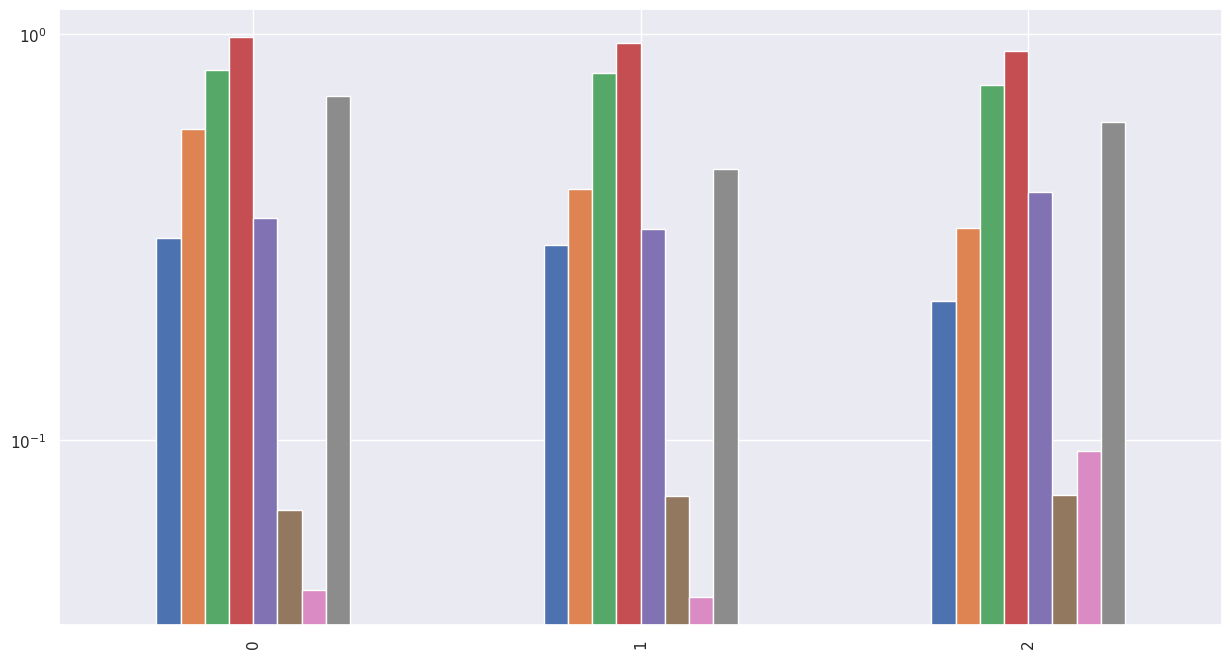

In [423]:
X_normalized[:3].plot(kind='bar', legend=False, logy=True);

In [424]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [425]:
X['Model'] = ord.squeeze()

In [426]:
X.columns

Index(['QED', '# Heteroatoms', 'Synthetic Complexity',
       'Synthetic Accessibility', 'Weighted Interaction Similarity',
       'Docking score', 'RMSD', 'Interaction Weight Ratio', 'Model'],
      dtype='object')

In [427]:
X.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,QED,# Heteroatoms,Synthetic Complexity,Synthetic Accessibility,Weighted Interaction Similarity,Docking score,RMSD,Interaction Weight Ratio,Model
QED,1.000000,-0.068655,-0.813805,0.187683,0.311015,0.639950,0.437604,-0.409032,0.478375
# Heteroatoms,-0.068655,1.000000,0.151144,-0.323283,-0.116606,0.087576,-0.061436,-0.061780,0.252241
Synthetic Complexity,-0.813805,0.151144,1.000000,-0.226563,-0.465996,-0.677420,-0.385222,0.505579,-0.566250
Synthetic Accessibility,0.187683,-0.323283,-0.226563,1.000000,0.221235,0.041760,0.095352,0.008817,-0.013418
Weighted Interaction Similarity,0.311015,-0.116606,-0.465996,0.221235,1.000000,0.146683,-0.028003,-0.002397,0.222507
Docking score,0.639950,0.087576,-0.677420,0.041760,0.146683,1.000000,0.634950,-0.625218,0.311697
RMSD,0.437604,-0.061436,-0.385222,0.095352,-0.028003,0.634950,1.000000,-0.420558,0.011494
Interaction Weight Ratio,-0.409032,-0.061780,0.505579,0.008817,-0.002397,-0.625218,-0.420558,1.000000,-0.443393
Model,0.478375,0.252241,-0.566250,-0.013418,0.222507,0.311697,0.011494,-0.443393,1.000000


In [428]:
corrs = X.iloc[:15].copy()

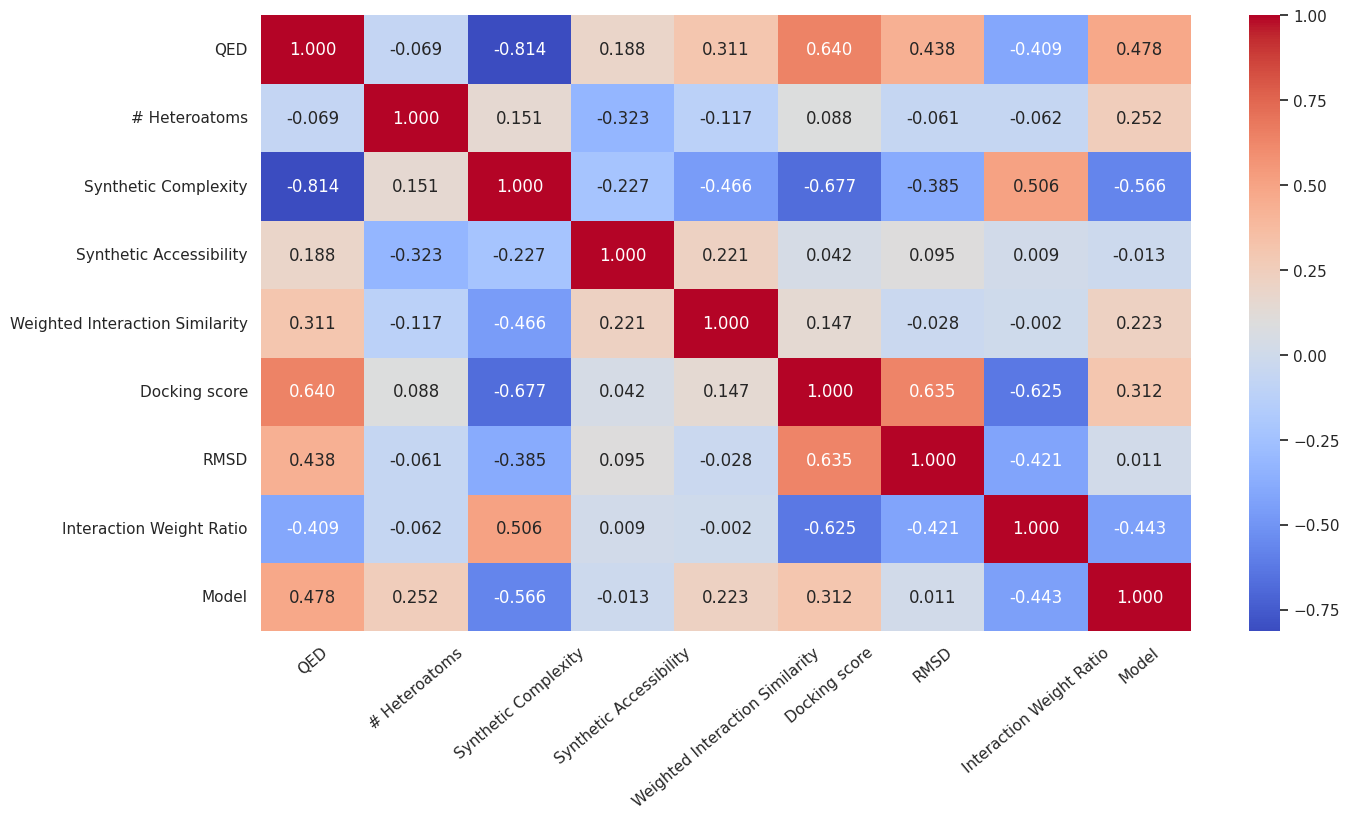

In [429]:
fig, ax = plt.subplots()
sns.heatmap(X.corr(method='pearson'), annot=True, fmt='.3f', 
            cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.xticks(rotation=40);

## Random Forest Classification

In [430]:
enc = OneHotEncoder(handle_unknown='ignore')

In [431]:
enc.fit_transform(y)

<794x4 sparse matrix of type '<class 'numpy.float64'>'
	with 794 stored elements in Compressed Sparse Row format>

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.2, random_state=1)

In [433]:
len(X_train)

635

In [434]:
len(X_test)

159

In [435]:
rf = RandomForestClassifier(n_estimators=250,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=250,
                       random_state=1)

In [436]:
y_pred = rf.predict(X_test)

In [437]:
precision = precision_score(y_pred, y_test, average='micro')

print(f'Average precision: {precision:.3f}')

print(classification_report(y_test, y_pred))

Average precision: 0.912
              precision    recall  f1-score   support

       coati       0.93      0.85      0.89        48
        crem       0.92      0.92      0.92        37
    reinvent       0.87      0.92      0.89        37
        safe       0.92      0.97      0.95        37

    accuracy                           0.91       159
   macro avg       0.91      0.92      0.91       159
weighted avg       0.91      0.91      0.91       159



In [438]:
weights = rf.feature_importances_
vars = X_normalized.columns

d = {'Features': vars, 'Weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['Weights'], ascending=False, ignore_index=True)

rf_features

,Features,Weights
0,Synthetic Complexity,0.206228
1,Weighted Interaction Similarity,0.176121
2,RMSD,0.147700
3,QED,0.146898
4,Docking score,0.146407
5,Interaction Weight Ratio,0.076167
6,Synthetic Accessibility,0.060994
7,# Heteroatoms,0.039485


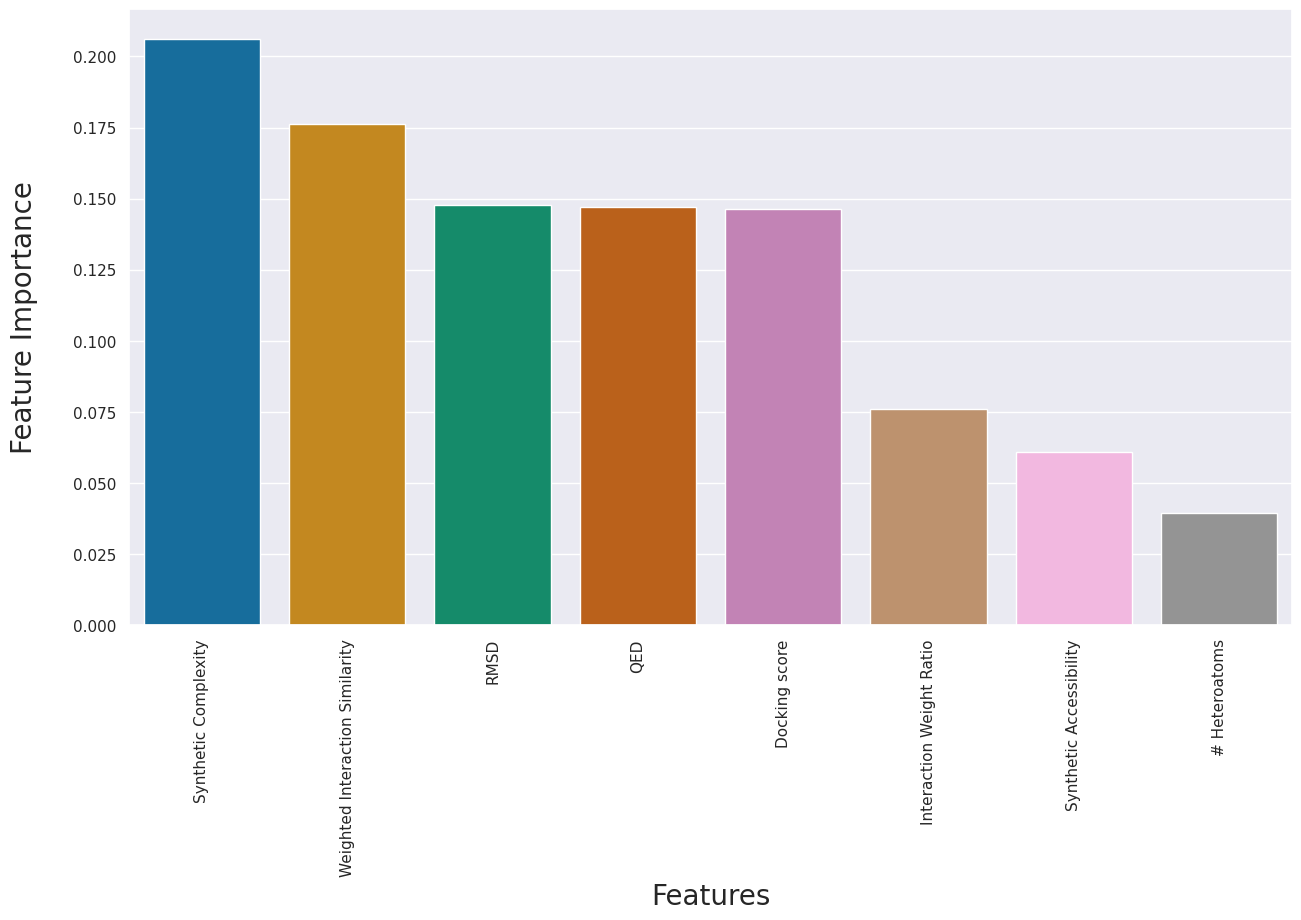

In [439]:
fig, ax = plt.subplots()

sns.barplot(x = 'Features',
			y = 'Weights',
			data = rf_features.loc[:15],
            palette='colorblind',
            ax=ax)

# plt.title('Ranking of Random Forest Features')
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Feature Importance', labelpad=25, fontsize=20)

plt.xticks(rotation=90)

# Show the plot
plt.show()


## Visualizations

### Visualizing Model Differences

In [496]:
X['SMILES'] = df['smiles']
X['Tanimoto'] = df['tanimoto_Sim']

In [497]:
X.to_csv('data/features')

In [441]:
model_df['Weighted Interaction Similarity'] = X['Weighted Interaction Similarity']

In [442]:
df = df.merge(model_df[['SMILES', 'Model', 'Docking score', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic', 'rmsd', 'Weighted Interaction Similarity']], left_on='smiles', right_on='SMILES', how='left')

In [443]:
df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,Model,Docking score,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,rmsd,Weighted Interaction Similarity
0,mol2mol,feature_selection,1,0,3.020867,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,reinvent,-16.624857,27.0,45.0,13.0,10.0,4.0,0.0,3.737471,0.888889
1,mol2mol,feature_selection,1,1,3.020867,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,reinvent,-16.540930,32.0,48.0,17.0,11.0,3.0,0.0,3.676144,0.702128
2,mol2mol,feature_selection,1,2,3.020867,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,reinvent,-16.529593,25.0,40.0,11.0,10.0,3.0,0.0,5.569642,0.923077
3,mol2mol,feature_selection,1,3,3.020867,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,reinvent,-16.301600,29.0,45.0,16.0,10.0,3.0,0.0,3.785833,0.875000
4,mol2mol,feature_selection,1,4,3.020867,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,reinvent,-16.295380,27.0,42.0,14.0,11.0,2.0,0.0,5.360354,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,mol2mol,feature_selection,1,789,3.020867,COc1ccc(C2Oc3ccccc3C3CC(O)CCC32CNS(=O)(=O)c2cc...,True,1,True,0,...,safe,-4.553764,32.0,45.0,20.0,8.0,3.0,0.0,11.936667,0.837209
830,mol2mol,feature_selection,1,790,3.020867,Cc1ccccc1Cc1noc(C[NH+]2CCC(C(N)=O)([NH+]3CCCCC...,True,1,True,0,...,safe,-4.448764,26.0,37.0,15.0,11.0,0.0,0.0,20.377477,0.782609
831,mol2mol,feature_selection,1,791,3.020867,CCOc1ccc([C@@H](C)NC(=O)CNC(=O)c2cccc(F)c2)cc1OCC,True,1,True,0,...,safe,-4.304027,27.0,38.0,16.0,11.0,0.0,0.0,10.296834,0.886364
832,mol2mol,feature_selection,1,792,3.020867,COc1ccc(OC)c([C@@H]2CC(=O)C3=C(C2)Nc2ccccc2N[C...,True,1,True,0,...,safe,-3.098856,33.0,46.0,21.0,11.0,1.0,0.0,24.215099,0.833333


In [445]:
df.drop(['SMILES'], axis=1, inplace=True)

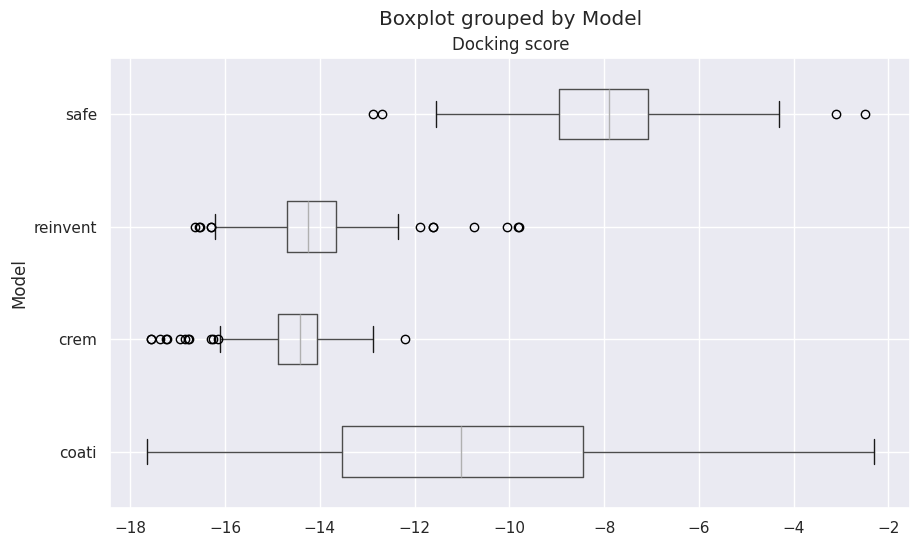

In [446]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['Docking score'], by='Model', ax=ax, **params)

ax = plt.gca()

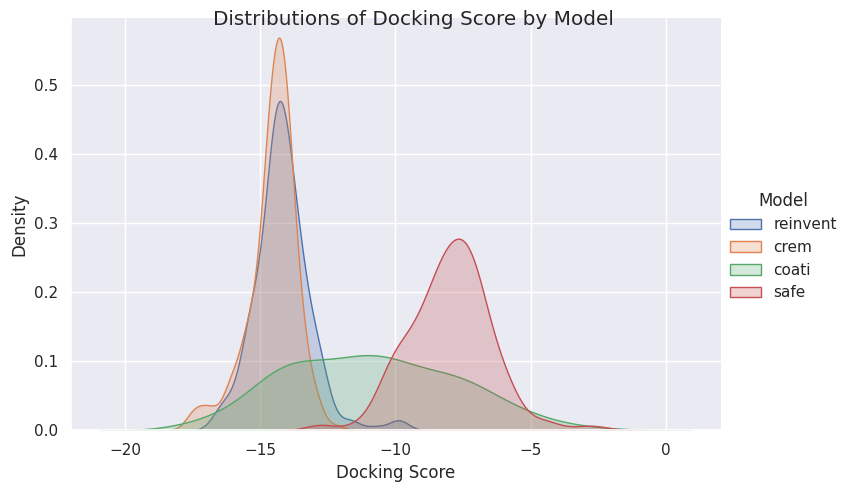

In [447]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "Docking score", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Distributions of Docking Score by Model')
g.set_axis_labels('Docking Score', 'Density')

plt.show()

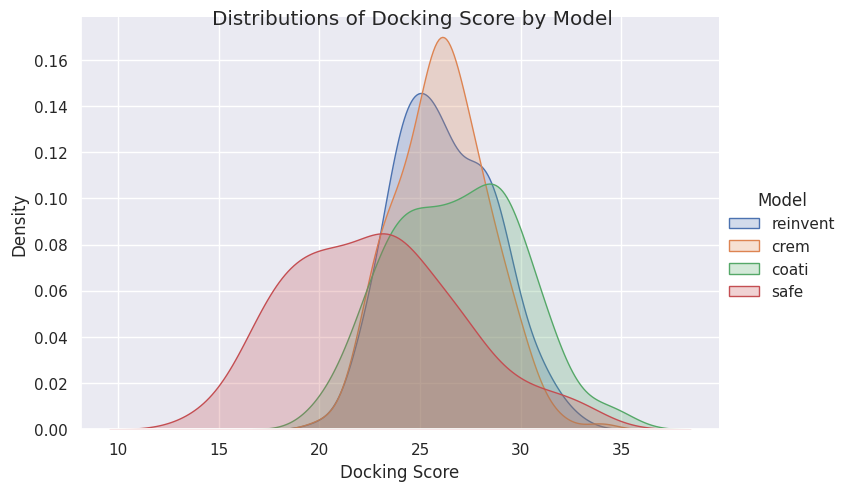

In [475]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "num_interactions", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Distributions of Docking Score by Model')
g.set_axis_labels('Docking Score', 'Density')

plt.show()

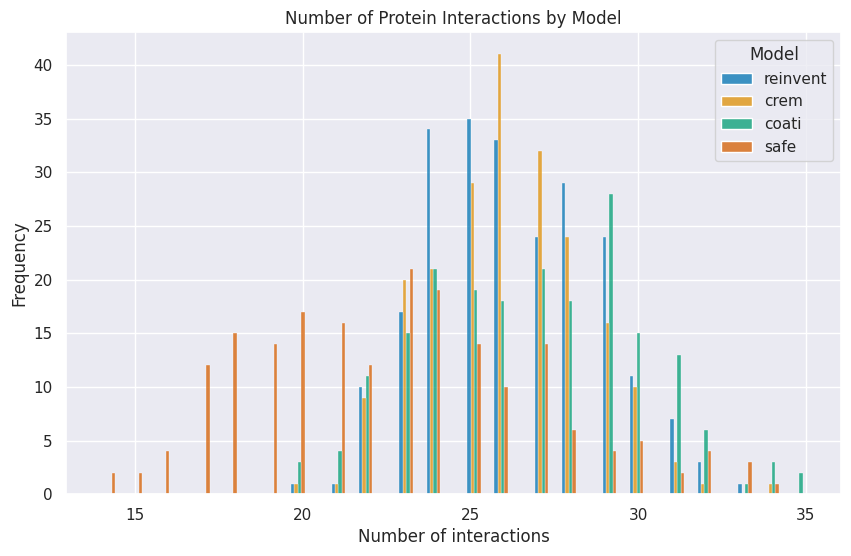

In [473]:
var = 'num_interactions'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.4,)

plt.xlabel('Number of interactions')
plt.ylabel('Frequency')
plt.title('Number of Protein Interactions by Model')

plt.show();

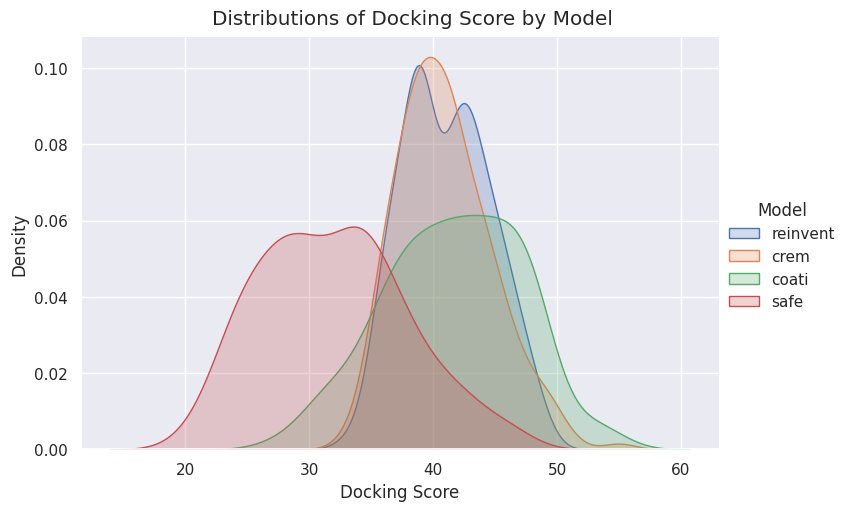

In [490]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "weighted_interactions", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Distributions of Docking Score by Model', y=1.02)
g.set_axis_labels('Docking Score', 'Density')

plt.show()

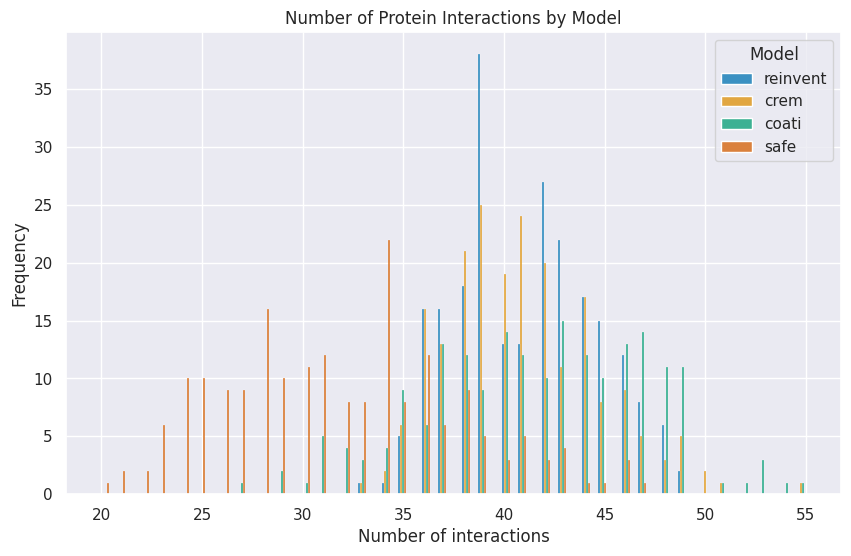

In [474]:
var = 'weighted_interactions'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.4,)

plt.xlabel('Number of interactions')
plt.ylabel('Frequency')
plt.title('Number of Protein Interactions by Model')

plt.show();

KeyError: "None of [Index(['Weighted IFP Similarity'], dtype='object')] are in the [columns]"

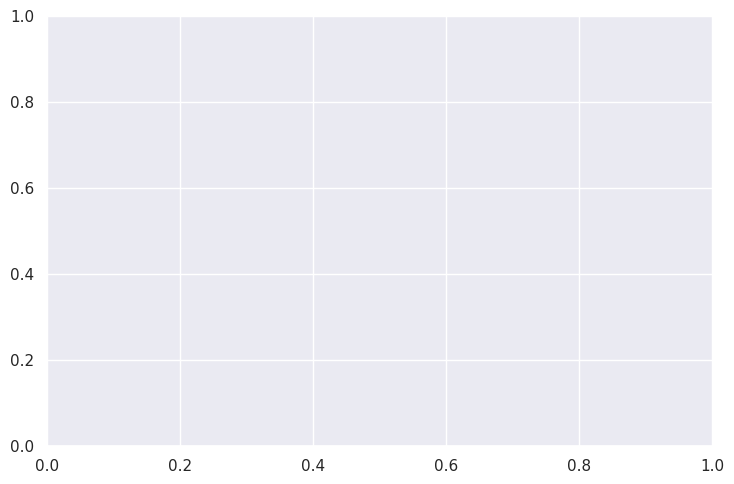

In [492]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "Weighted IFP Similarity", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Weighted IFP Similarity by Model', y=1.02)
g.set_axis_labels('Weighted Interaction Similarity', 'Density')

plt.show()

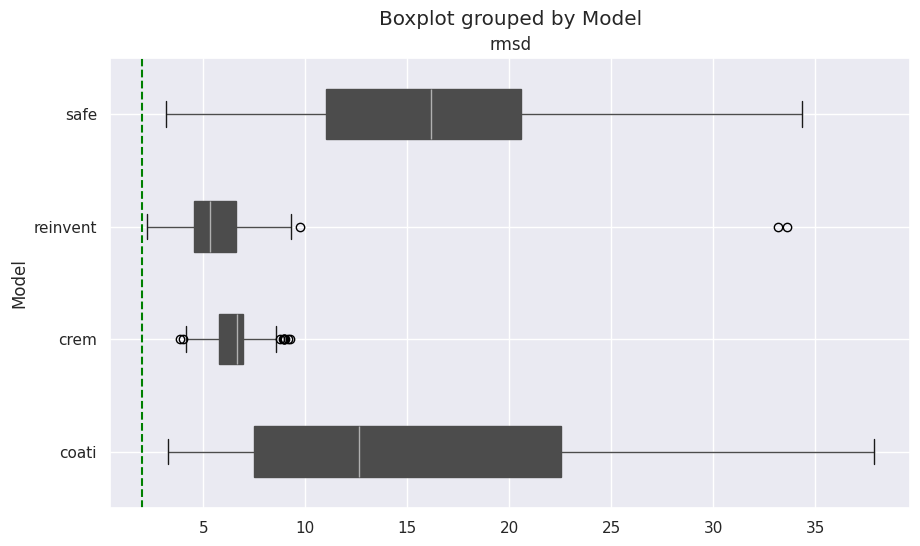

In [488]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0,
          'patch_artist' : True}

df.boxplot(column=['rmsd'], by='Model', ax=ax, **params)

ax = plt.gca()

plt.axvline(x=2, ls='dashed', c='green');

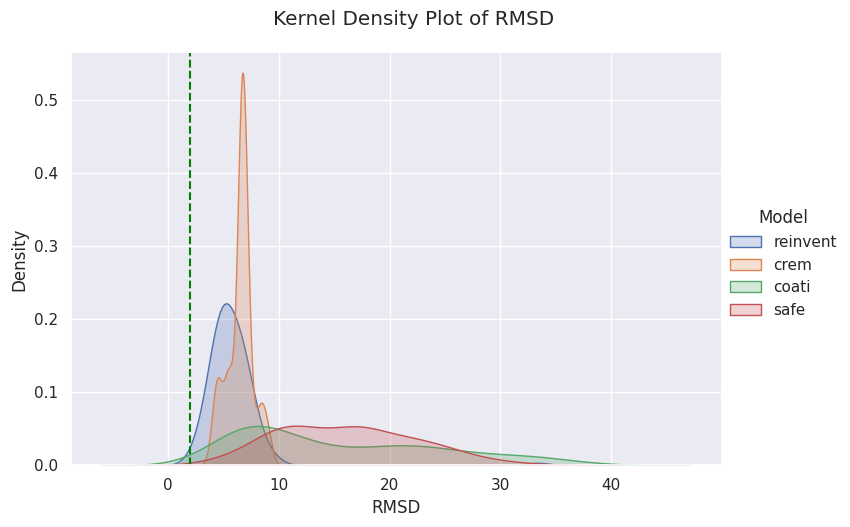

In [484]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "rmsd", shade=True).add_legend()
plt.axvline(x=2, ls='dashed', c='green')

# Add title and labels
g.fig.suptitle('Kernel Density Plot of RMSD', y=1.05)
g.set_axis_labels('RMSD', 'Density')

plt.show()

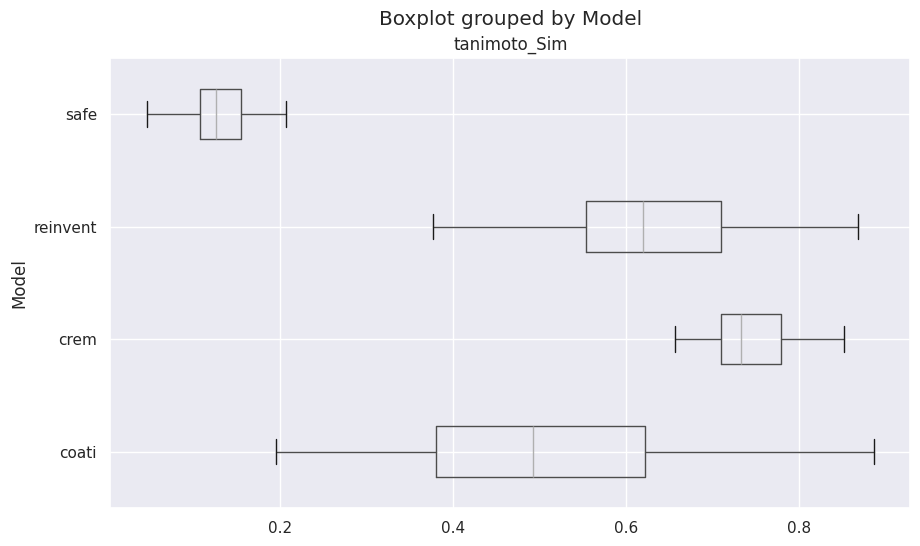

In [451]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['tanimoto_Sim'], by='Model', ax=ax, **params)

ax = plt.gca()

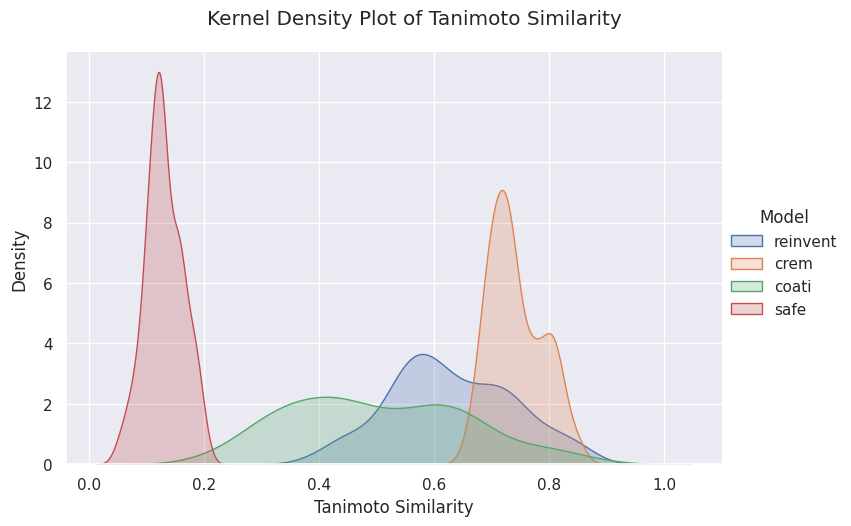

In [482]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "tanimoto_Sim", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Tanimoto Similarity', y=1.05)
g.set_axis_labels('Tanimoto Similarity', 'Density')

plt.show()

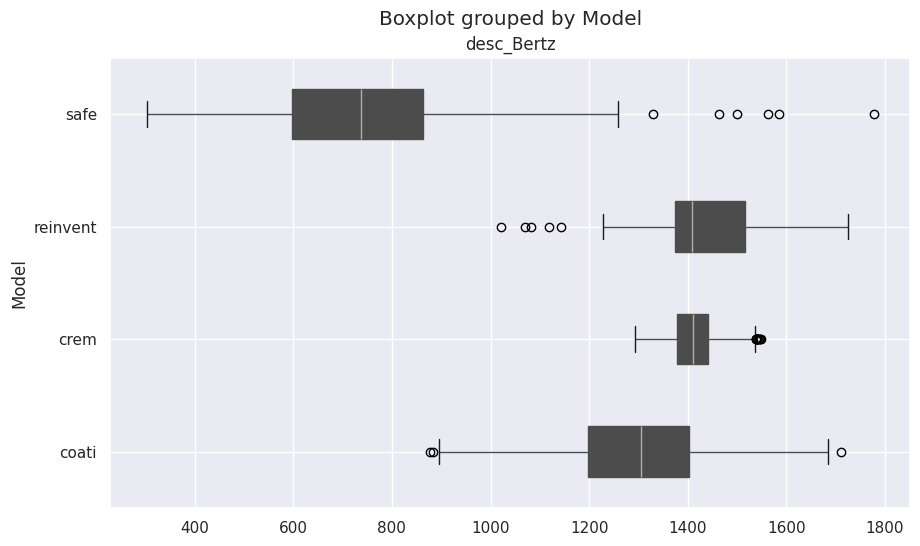

In [483]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0,
          'patch_artist' : True}

df.boxplot(column=['desc_Bertz'], by='Model', ax=ax, **params)

ax = plt.gca()

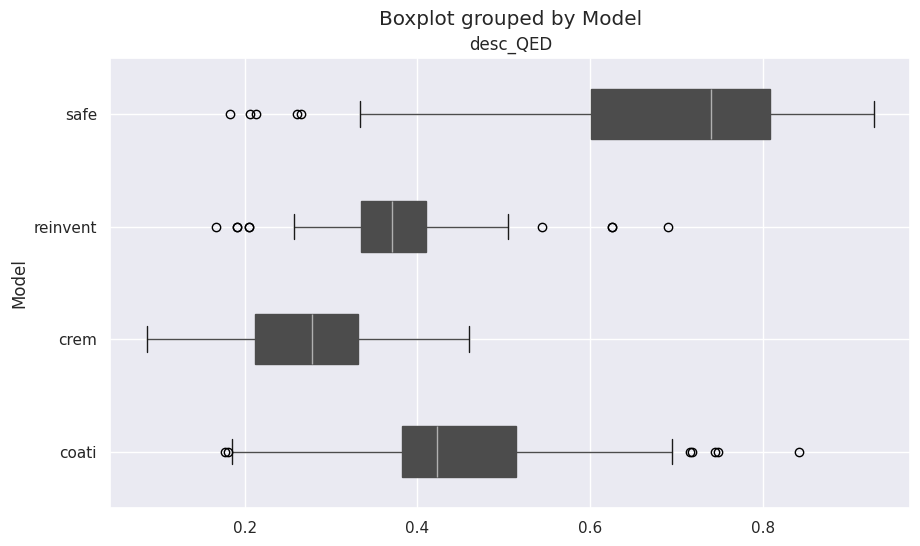

In [481]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0,
          'patch_artist' : True}

df.boxplot(column=['desc_QED'], by='Model', ax=ax, **params)

ax = plt.gca()

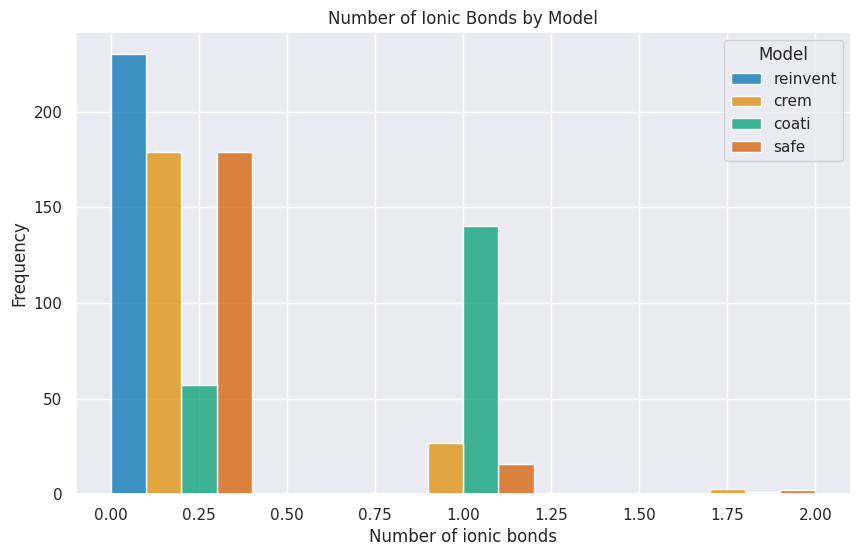

In [459]:
var = 'num_ionic'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.4,)

plt.xlabel('Number of ionic bonds')
plt.ylabel('Frequency')
plt.title('Number of Ionic Bonds by Model')

plt.show();

### Visualizing clusters w/ PCA and t-SNE

In [379]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_normalized)

In [380]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X_normalized)

In [381]:
var1, var2, var3 = pca.explained_variance_ratio_

In [382]:
var1, var2, var3

(0.4210518078338181, 0.19243790967679, 0.12731058072867343)

In [383]:
model_df['PC1'], model_df['PC2'], model_df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [384]:
plot_df = model_df.sample(500)

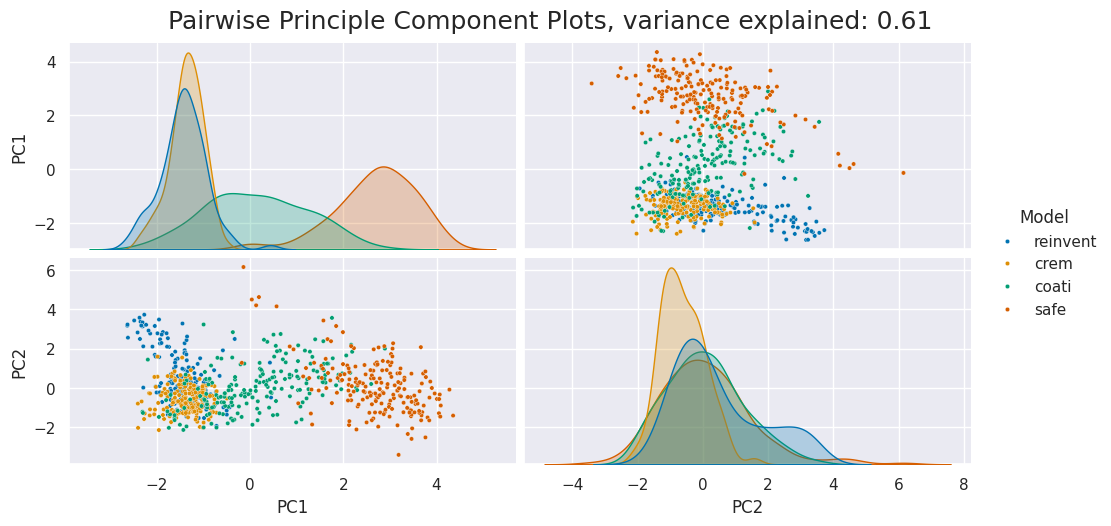

In [385]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['PC1', 'PC2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle(f'Pairwise Principle Component Plots, variance explained: {var1 + var2:.2f}', fontsize=18, y=1.04);

In [386]:
p = 50

pca_model = PCA(n_components=3, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

ValueError: could not convert string to float: 'CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1Cc1ccc(C(=O)O)cc1'

In [ ]:
model_df['TSNE1'], model_df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [ ]:
plot_df = df.sample(n=500)

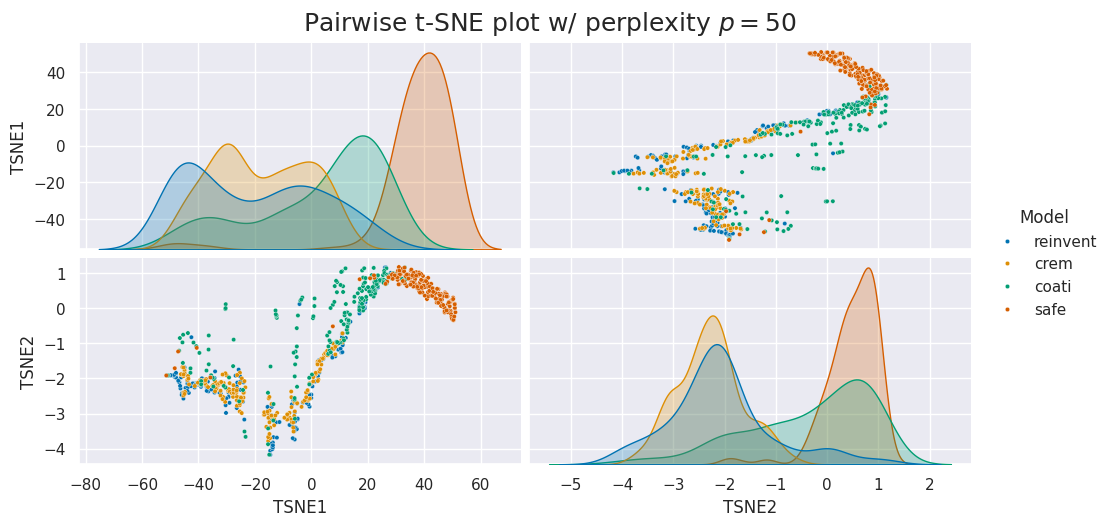

In [ ]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);